In [1]:
# LangChain supports many other chat models. Here, we're using Ollama
from langchain_community.chat_models import ChatOllama

from langchain_core.prompts import ChatPromptTemplate
from langchain.prompts import PromptTemplate

from langchain_core.output_parsers import StrOutputParser

In [2]:
# class to view the latest available supported parameters
llm = ChatOllama(model="llama3")

# Example
prompt = ChatPromptTemplate.from_template("Tell me briefly what you know about {topic}")
chain = prompt | llm | StrOutputParser()
print(chain.invoke({"topic": "Venice of time 1741"}))

I think there may be a mistake here!

There is no "Venice of Time" from 1741. Venice is a city in Italy, known for its canals, ornate bridges, and stunning architecture. It has a rich history dating back to the 5th century.

If you meant to ask about something else, please let me know!


In [3]:
import pandas as pd
import numpy as np

questions = pd.read_csv('data/questions.csv')
questions

,question,category,answer_format,dataset,n_matches
0,What is the average rent price for properties ...,spatial,numerical,catastici,1
1,Which square has the highest density of tenant...,spatial,entity,catastici,1
2,Is the price of the rent correlated with the d...,spatial,yes/no,catastici,1
3,Where are the houses densely located in 1740?,spatial,entity,catastici,1
4,Are low-rent properties clustered in specific ...,spatial,yes/no,catastici,0
...,...,...,...,...,...
107,Did the number of buildings with more than one...,comparison,yes/no,"catastici, sommarioni",0
108,Which parish has the most diverse range of bui...,spatial,entity,catastici,0
109,Which district has the most diverse range of b...,spatial,entity,sommarioni,0
110,Are there any parishes with more than 5 buildi...,spatial,yes/no,catastici,0


# Entity name detector

In [4]:
# Entity name detector
from prompts import prompt_extract_column_template, prompt_extract_row_template
import re
import ast

def get_llm(model='llama3', repeat_penalty=1.1, temperature=0.8, top_k=40, top_p=0.9):
    llm = ChatOllama(model=model, repeat_penalty=repeat_penalty, temperature=temperature, top_k=top_k, top_p=top_p)
    
    return llm

def extract_column_info(input_string):
    # Use regular expression to find the pattern
    pattern = r"\[\(.*?\)\]"
    matches = re.findall(pattern, input_string)

    try:
        if matches:
            matches = ast.literal_eval(matches[0]) 
    except:
        matches = []

    return matches

def is_in_column(input_string):
    return bool("True" in input_string)
    
# Extract column
prompt_extract_column = PromptTemplate(
    template=prompt_extract_column_template,
    input_variables=["question"],
)
llm = llm = get_llm(top_k=1)
column_extractor = prompt_extract_column | llm | StrOutputParser()

# Extract row
prompt_extract_row = PromptTemplate(
    template=prompt_extract_row_template,
    input_variables=["question"],
)
llm = llm = get_llm(top_k=1)
row_extractor = prompt_extract_row | llm | StrOutputParser()

### Find matches

In [32]:
from rapidfuzz import fuzz
from sentence_transformers import SentenceTransformer, util

MODEL = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
DATASET_PATHS = {1: "data/buildings_1740.csv", 2: "data/buildings_1808.csv", 3: "data/landmarks.csv"}

def exact_search(query, strings):
    """
    Perform an exact search on a list of strings and return values with a similarity score higher than threshold.
    """
    if query in strings:
        return [query]
    else:
        return []

def fuzzy_search(query, strings, threshold=70):
    """
    Perform a fuzzy similarity search on a list of strings and return values with a similarity score higher than threshold.
    Relies on Levenshtein Distance: Measures the minimum number of single-character edits (insertions, deletions, or substitutions) required to change one word into the other.
    """
    strings_str = strings.astype(str)
    return [string for string in strings_str if fuzz.ratio(string, query) > threshold]


def similarity_search(query, strings, threshold=0.7):
    """
    Perform a similarity search on a list of strings and return values with a similarity score higher than threshold.
    """
    strings_str = strings.astype(str)

    query_embedding = MODEL.encode(query, convert_to_tensor=True)
    strings_embeddings = MODEL.encode(strings_str, convert_to_tensor=True)
    
    similarities = util.pytorch_cos_sim(query_embedding, strings_embeddings)[0]
    result = [strings_str[i] for i in range(len(strings_str)) if similarities[i] > threshold]
    
    return result

In [34]:
## Examples ##
strings = np.array(["casa", "bottega", "appartamento", "magazzeno"])

# Exact search
print('----- Exact search -----')
result = exact_search("casa", strings)
print(result)

result = exact_search("apartment", strings)
print(result)

result = exact_search("house", strings)
print(result)

# Fuzzy search
print('----- Fuzzy search -----')
result = fuzzy_search("casa", strings)
print(result)

result = fuzzy_search("apartment", strings)
print(result)

result = fuzzy_search("house", strings)
print(result)

# Similarity search
print('----- Similarity search -----')
result = similarity_search("casa", strings)
print(result)

result = similarity_search("apartment", strings)
print(result)

result = similarity_search("house", strings)
print(result)

----- Exact search -----
['casa']
[]
[]
----- Fuzzy search -----
['casa']
['appartamento']
[]
----- Similarity search -----
['casa', 'appartamento']
['casa', 'appartamento']
['casa', 'appartamento']


[]
['bottega', 'bottega olio']
['bottrghetta', 'bottega']


['bottega']
['bottega', 'bottega olio']
['casa', 'bottega', 'bottega olio']


# Coding

In [28]:
import sys
from io import StringIO

from prompts import prompt_plan, prompt_code, prompt_debug

from langchain_experimental.utilities import PythonREPL
python_repl = PythonREPL()

def execute_code(code):
    return python_repl.run(code).strip()

# def execute_code(code):
#     global_namespace = globals().copy()
#     local_namespace = locals().copy()
#     combined_namespace = {**global_namespace, **local_namespace}
    
#     # Redirect stdout to capture printed output
#     stdout_orig = sys.stdout
#     sys.stdout = StringIO()

#     try:
#         # Execute the code in the combined namespace
#         exec(code, combined_namespace)

#         # Get the captured output
#         output = sys.stdout.getvalue()
#         return output.strip()
#     finally:
#         # Restore stdout
#         sys.stdout = stdout_orig

def get_llm(model='llama3', repeat_penalty=1.1, temperature=0.8, top_k=40, top_p=0.9):
    llm = ChatOllama(model=model, repeat_penalty=repeat_penalty, temperature=temperature, top_k=top_k, top_p=top_p)
    
    return llm

def extract_python_code(text):
    # Find all code block matches in the text
    pattern = r'```python(.*?)```|```\s*(.*?)```|```Python(.*?)```'
    matches = re.findall(pattern, text, re.DOTALL)
    
    # Extract the code from matches
    code_blocks = [match[0] if match[0] else match[1] for match in matches]
    code_blocks = [code_block[len('python'):].lstrip() if code_block.lower().startswith('python') else code_block for code_block in code_blocks]
    code = '\n\n'.join(code_blocks).strip()
    
    return code

### Planner

In [10]:
def get_planner():
    llm = get_llm(top_k=5)

    planner_prompt = PromptTemplate(
        template=prompt_plan,
        input_variables=["question", "entities_matches"],
    )

    planner = planner_prompt | llm | StrOutputParser()

    return planner

### Coder

In [11]:
def get_coder():
    llm = get_llm(top_k=5)

    coder_prompt = PromptTemplate(
        template=prompt_code,
        input_variables=['answer_type', "question", "entities_matches", "plan"],
    )

    coder = coder_prompt | llm | StrOutputParser()

    return coder

### Debugger

In [12]:
def get_debugger():
    llm = get_llm(top_k=5)

    debugger_prompt = PromptTemplate(
        template=prompt_debug,
        input_variables=["question", "entities_matches", "plan", "code", "error_message"],
    )

    debugger = debugger_prompt | llm | StrOutputParser()

    return debugger

# Building the Graph (Putting it all together)

In [13]:
from typing_extensions import TypedDict
from typing import List

### State
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        entities_matches: matched values of the entities
        plan: analysis plan
        code: code
        error_message: error message
        num_steps: number of steps
        output: output of the code
    """
    question : str
    column_references: dict
    row_matches : dict
    answer_format: str
    plan : str
    code : str
    error_message: str
    num_steps : int
    output: str

### Nodes

In [14]:

def find_references(state):
    """Map the phrases in the question to column and rows"""
    question = state['question']

    # column extractor
    column_mappings = column_extractor.invoke({"question": question})
    column_mappings = extract_column_info(column_mappings)

    # row extractor
    in_columns = []
    for mapping in column_mappings:
        in_column = row_extractor.invoke({"question":question, "mapping":mapping})
        in_columns.append(is_in_column(in_column))

    # Extract column and row references
    column_references = {}
    row_references = {}
    for in_col, phrase in zip(in_columns, column_mappings):
        if len(phrase) != 3:
            continue
        try:
            # get phrase info
            phrase_name = phrase[0].lower()
            phrase_column = phrase[1].lower()
            phrase_dataset = phrase[2]
            
            # get the column values from the dataset
            dataset = pd.read_csv(DATASET_PATHS[int(phrase_dataset)])
            columns = dataset.columns

            # column reference
            if (not in_col) & (phrase_column in columns):
                column_references[phrase_name] = {
                    'dataset_path': DATASET_PATHS[int(phrase_dataset)],
                    'column': phrase_column
                }

            # row reference
            if (in_col) & (phrase_column in columns):
                row_references[phrase_name] = {
                    'dataset_path': DATASET_PATHS[int(phrase_dataset)],
                    'column': phrase_column
                }
        except:
            continue

    print("--------------- Phrase Column References ---------------")
    print(column_references, end='\n\n')

    return {"column_references": column_references, "row_matches": row_references}

def find_matches(state):
    """ """
    row_references = state['row_matches']

    # initialize row matches
    row_matches = {}

    for phrase_name, references in row_references.items():
        # get reference info
        dataset_path = references['dataset_path']
        column = references['column']
        
        # get the column values from the dataset
        dataset = pd.read_csv(dataset_path)
        dataset = dataset[dataset[column].notna()]
        column_values = dataset[column].unique()
    
        # get exact matching
        matches = exact_search(phrase_name, column_values)
    
        # fuzzy search
        if len(matches) == 0:
            matches = fuzzy_search(phrase_name, column_values)
    
        # similarity search
        threshold = 0.9
        while len(matches) == 0 and threshold >= 0.5:
            matches = similarity_search(phrase_name, column_values, threshold=threshold)
            threshold -= 0.05
    
        # skip this entity if not matches are found with at least 50% of similarity
        if len(matches) == 0:
            break
    
        # collect the matches
        row_matches[phrase_name] = {
            'dataset_path': dataset_path,
            'column': column,
            'matches': matches
        }

    print("--------------- Row Matches ---------------")
    print(row_matches, end='\n\n')

    return {"row_matches": row_matches}

In [15]:
def create_plan(state):
    """creates a plan to answer the question"""
    question = state['question']
    entities_matches = state['row_matches']
    references = state['column_references']
    answer_format = state['answer_format']

    # create the plan
    planner = get_planner()
    plan = planner.invoke({
            "question": question, 
            "entities_matches": entities_matches, 
            "references": references, 
            "answer_format": answer_format
        })

    print("--------------- Plan ---------------")
    print(plan, end='\n\n')

    return {"plan": plan}

In [16]:
def write_code(state):
    """writes / debugs a code following the given plan / error message"""
    question = state['question']
    entities_matches = state['row_matches']
    references = state['column_references']
    answer_format = state['answer_format']
    plan = state['plan']
    code = state['code']
    error_message = state['error_message']
    num_steps = state['num_steps']

    # Generate or Debug the code
    if error_message is None:
        coder = get_coder()
        code = coder.invoke({
                "question": question, 
                "plan": plan,
                "answer_format": answer_format
            })
    else:
        debugger = get_debugger()
        code = debugger.invoke({
                "question": question, 
                "entities_matches": entities_matches, 
                "references": references, 
                "plan": plan, 
                "code": code, 
                "error_message": error_message,
                "answer_format": answer_format
            })

    # extract the code block
    code_block = extract_python_code(code)
    
    print("--------------- Code ---------------")
    print(code_block, end='\n\n')

    num_steps += 1
    
    return {"code": code_block, "num_steps": num_steps}

In [17]:
import traceback

def execute(state):
    """executes the given code"""
    code = state['code']

    # execute the code
    try:
        print("--------------- Output ---------------")
        output = execute_code(code)
        print(output, end='\n\n')

        return {'output': output, "error_message": None}

    except Exception:
        error_message = traceback.format_exc()

        print("--------------- Error ---------------")
        print(error_message, end='\n\n')

        return {'output': None, "error_message": error_message}

### Edges

In [18]:
def check_row_matches(state):
    """decides whether to go to planner or entity matcher"""
    row_references = state['row_matches']

    if len(row_references) == 0:
        return "create_plan"
    else:
        return "find_matches"

max_num_steps = 10

def check_output(state: GraphState):
    """determines whether to finish."""
    error_message = state["error_message"]
    num_steps = state["num_steps"]

    if (error_message is None) or (num_steps == max_num_steps):
        return "end"
    else:
        return "debug"

In [19]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes 
workflow.add_node("find_references", find_references)
workflow.add_node("find_matches", find_matches)
workflow.add_node("create_plan", create_plan)
workflow.add_node("write_code", write_code)
workflow.add_node("execute", execute)

# Build graph
workflow.set_entry_point("find_references")
workflow.add_conditional_edges(
    "find_references",
    check_row_matches,
    {
        "create_plan": "create_plan",
        "find_matches": "find_matches",
    },
)
workflow.add_edge("find_matches", "create_plan")
workflow.add_edge("create_plan", "write_code")
workflow.add_edge("write_code", "execute")
workflow.add_conditional_edges(
    "execute",
    check_output,
    {
        "degub": "write_code",
        "end": END,
    },
)

app = workflow.compile()

## Demo

#### Graph

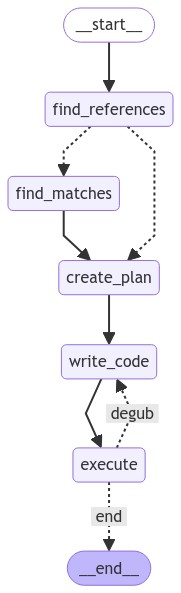

In [23]:
from IPython.display import Image, display

# Visualize the graph
display(Image(app.get_graph().draw_mermaid_png()))

In [21]:
question = questions.iloc[49]
question

question         How many families present in Venice in 1740 st...
category                                                comparison
answer_format                                            numerical
dataset                                      catastici, sommarioni
n_matches                                                        0
Name: 49, dtype: object

In [22]:
# for i, question in questions.tail(10).iterrows():
final_state = app.invoke({
    "question": question['question'],
    "answer_format": question['answer_format'],
    "num_steps": 0
})
print(final_state['question'])
print(final_state['answer_format'])
print(final_state['column_references'])
print(final_state['row_matches'])
print(final_state['plan'])
print(final_state['code'])
print(final_state['error_message'])
print(final_state['output'])
print('',end='\n\n\n\n')

--------------- Phrase Column References ---------------
{'families': {'dataset_path': 'data/buildings_1808.csv', 'column': 'owner_family_name'}}

--------------- Plan ---------------
Here is a step-by-step plan to answer the question:

**Step 1: Load the required datasets**

* Load the "1740 Buildings Dataset" into a pandas dataframe using `pd.read_csv()`. The dataset path is not provided, but based on the problem statement, it's assumed that the file name is 'data/buildings_1740.csv' and the column of interest is 'owner_family_name'.
* Load the "1808 Buildings Dataset" into another pandas dataframe using `pd.read_csv()`. The dataset path is provided as 'data/buildings_1808.csv', and the column of interest is also 'owner_family_name'.

**Step 2: Extract unique family names from the 1740 dataset**

* Use the pandas `unique()` function to extract a list of unique family names from the 'owner_family_name' column in the 1740 dataset. This will give us the set of families present in Venice

Python REPL can execute arbitrary code. Use with caution.


--------------- Code ---------------
import pandas as pd

# Load datasets
df_1740 = pd.read_csv('data/buildings_1740.csv')
df_1808 = pd.read_csv('data/buildings_1808.csv')

# Extract unique family names from 1740 dataset
unique_families_1740 = df_1740['owner_family_name'].dropna().str.lower().unique()

# Filter 1808 dataset for matching family names
df_1808_matched = df_1808[df_1808['owner_family_name'].str.lower().isin(unique_families_1740)]

# Count the number of matching family names
num_matching_families = len(df_1808_matched)

print(num_matching_families)  # Output: numerical value

--------------- Output ---------------
11751


How many families present in Venice in 1740 still exist in 1808?
numerical
{'families': {'dataset_path': 'data/buildings_1808.csv', 'column': 'owner_family_name'}}
{}
Here is a step-by-step plan to answer the question:

**Step 1: Load the required datasets**

* Load the "1740 Buildings Dataset" into a pandas dataframe using `pd.read_csv()`. The dataset pat

In [111]:
final_state

{'question': 'How many families present in Venice in 1740 still exist in 1808?',
 'column_references': {'families': {'dataset_path': 'data/buildings_1808.csv',
   'column': 'owner_family_name'}},
 'row_matches': {},
 'answer_format': 'numerical',
 'plan': 'Here is the step-by-step plan to answer the question:\n\n**Step 1: Load the necessary datasets**\n\n* Load the "1740 Buildings Dataset" using `pandas.read_csv()` with the file path \'data/buildings_1740.csv\' and assign it to a variable, e.g., `df_1740`.\n* Load the "1808 Buildings Dataset" using `pandas.read_csv()` with the file path \'data/buildings_1808.csv\' and assign it to a variable, e.g., `df_1808`.\n\n**Step 2: Extract the owner family names from the 1740 dataset**\n\n* Filter the `df_1740` dataframe to only include rows where the column "owner_family_name" is not null or empty.\n* Extract the unique values from the filtered dataframe and store them in a list, e.g., `families_1740`.\n\n**Step 3: Extract the owner family name